# Films Recommender System

*Необходимо реализовать рекомендательную систему на кастомном датасете медиа контента*.

Выжимка: был применен ядерный метод (linear_kernel) для поиска кластеров. Как мера сходство было использовано косинусное расстояние. Для оценки качества работы полученной модели использовались: точность на K элементах, ее усреднение и (normalized) discounted cumulative gain.
В качестве признаков для преобразования использовалась комбинация из названия страны выпускающей фильм, его режиссера и жанров картины, которые были преобразованы с помощью TfidfVectorizer. 

Что здесь можно найти:

1. [Постановка задачи](#you_are_here)
2. [Анализ датасетов: films, titles, actors](#data_films)
3. [Анализ ratings](#data_raitins)
4. [Выбор алгоритма и Очистка данных](#cleaning)
5. [Подготовка данных](#data_preparation)
6. [Модель](#model)
7. [Анализ метрик](#metrics)
8. [Итоги](#conclusion)

## Постановка задачи
<a id='you_are_here'></a>

Для решения задачи рекомендации фильмов, при условии что не нужно изобретать многослойные архитектуры, поход к решению будет либо *коллабаративным*, либо *контенто-ориентированным*.

Для реализации первой основной упор будет делаться на пользователях и поиску симулярности в их оценках, во втором - ориентация на саму предметную область и общие особенности в разных фильмов.

Для того чтобы определиться с типом системы стоит взглянуть на датасет.

In [1]:
import pandas as pd
import seaborn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.metrics import average_precision_score, label_ranking_average_precision_score, ndcg_score, dcg_score
#from sklearn.metrics import top_k_accuracy_score
%matplotlib inline

In [2]:
df_actors = pd.read_csv('./data/actors.csv', index_col=0)
df_films = pd.read_csv('./data/films.csv', index_col='title_id')
df_title = pd.read_csv('./data/title_principals.csv', index_col='title_id')
df_ratings = pd.read_csv('./data/ratings.csv', index_col='title_id')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Всего четыре разных датасета. Оценим каждый

## Films
<a id='data_films'></a>

In [3]:
df_films.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85855 entries, tt0000009 to tt9914942
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             85855 non-null  int64  
 1   title                  85855 non-null  object 
 2   original_title         85855 non-null  object 
 3   year                   85855 non-null  object 
 4   date_published         85855 non-null  object 
 5   genre                  85855 non-null  object 
 6   duration               85855 non-null  int64  
 7   country                85791 non-null  object 
 8   language               85022 non-null  object 
 9   director               85768 non-null  object 
 10  writer                 84283 non-null  object 
 11  production_company     81400 non-null  object 
 12  actors                 85786 non-null  object 
 13  description            83740 non-null  object 
 14  avg_vote               85855 non-null  float64


In [4]:
df_films.head()

,Unnamed: 0,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
title_id,,,,,,,,,,,,,,,,,,,,,
tt0000009,0,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,...,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0
tt0000574,1,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0
tt0001892,2,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,NaN,NaN,NaN,NaN,5.0,2.0
tt0002101,3,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,446,$ 45000,NaN,NaN,NaN,25.0,3.0
tt0002130,4,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",...,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2237,NaN,NaN,NaN,NaN,31.0,14.0


В данных есть некоторые пропуски, часть столбцов скорее состоит из NaN, чем из чисел. В основном это информация о бюджете фильмов и о их сборах. Заполнять их средним значением для данного столбца не стоит, так как данных слишком мало - это раз, разброс в них очень большой - это два.  
Преобразуем столбец с датами к формату datetime.  
В одной ячейке столбца year были постороннее символы - их тоже убираем.  

In [5]:
df_films.loc[:, 'year'] = df_films.loc[:, 'year'].replace({'\D': ''}, regex=True)
df_films['date_published'] = pd.to_datetime(df_films['date_published'] ,errors ='coerce',format='%Y-%m-%d')

In [6]:
df_films['date_published'].fillna(method='ffill', inplace=True)

In [7]:
df_films.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85855 entries, tt0000009 to tt9914942
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Unnamed: 0             85855 non-null  int64         
 1   title                  85855 non-null  object        
 2   original_title         85855 non-null  object        
 3   year                   85855 non-null  object        
 4   date_published         85855 non-null  datetime64[ns]
 5   genre                  85855 non-null  object        
 6   duration               85855 non-null  int64         
 7   country                85791 non-null  object        
 8   language               85022 non-null  object        
 9   director               85768 non-null  object        
 10  writer                 84283 non-null  object        
 11  production_company     81400 non-null  object        
 12  actors                 85786 non-null  object        

In [8]:
df_films[['year', 'date_published']].head()

,year,date_published
title_id,,
tt0000009,1894,1894-10-09
tt0000574,1906,1906-12-26
tt0001892,1911,1911-08-19
tt0002101,1912,1912-11-13
tt0002130,1911,1911-03-06


<AxesSubplot:>

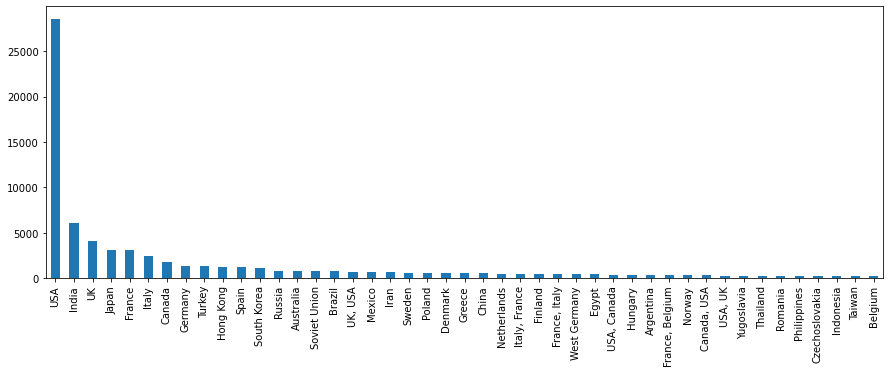

In [9]:
country  = df_films['country'].value_counts() 
country = country[country > 200]
country.plot.bar(figsize=(15,5))

<AxesSubplot:>

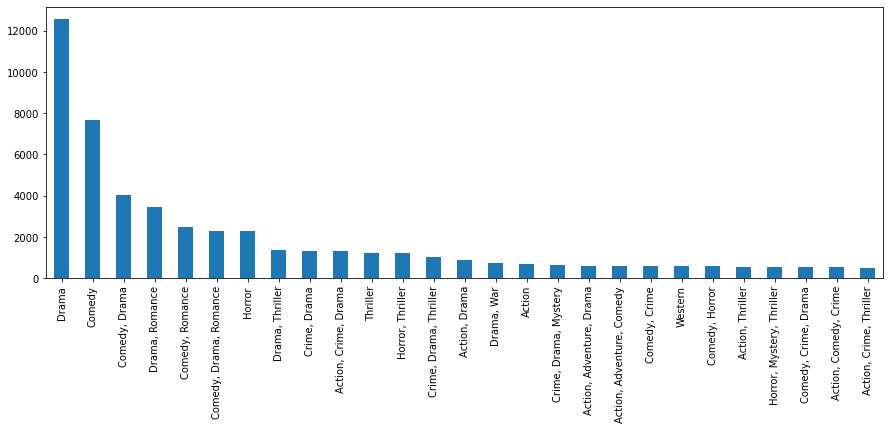

In [10]:
genre  = df_films['genre'].value_counts() 
genre = genre[genre > 500]
genre.plot.bar(figsize=(15,5))

<AxesSubplot:>

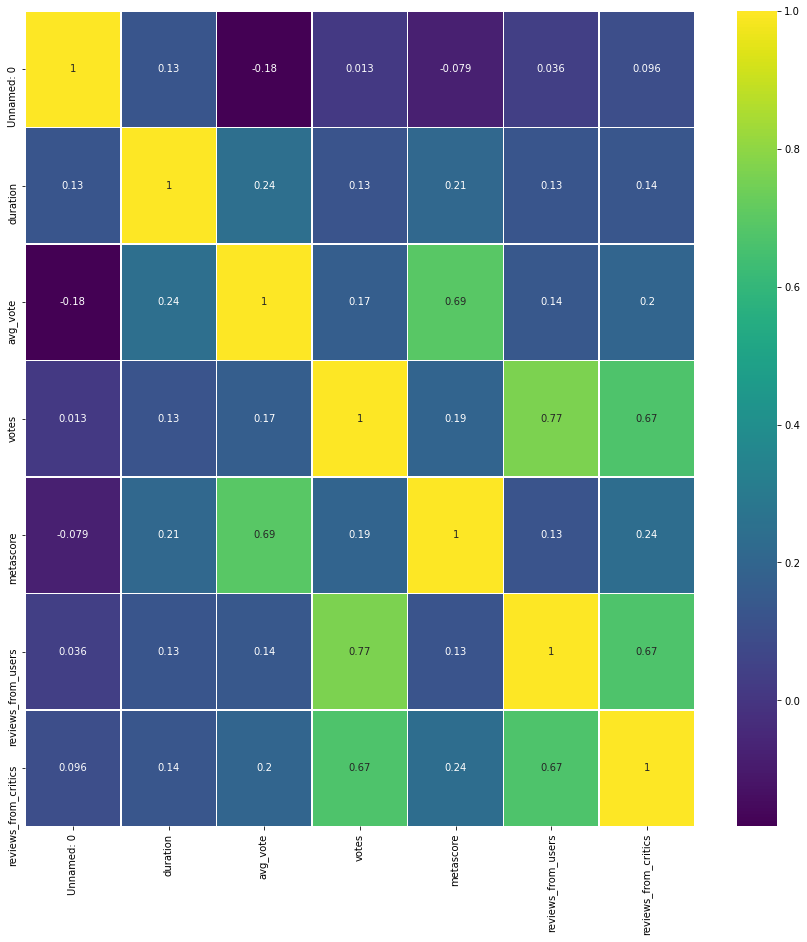

In [11]:
plt.figure(figsize=(15,15))
seaborn.heatmap(df_films.corr(),annot=True,cmap='viridis',linewidth=0.5)

Очень большой процент фильмов был снят в США, также можно выделить несколько явно доминирующих жанров.  
Однако численные значения столбцов слабо коррелируют.

## Title

In [12]:
df_title[:15]

,Unnamed: 0,ordering,name_id,category,job,characters
title_id,,,,,,
tt0000009,0,1,nm0063086,actress,NaN,"[""Miss Geraldine Holbrook (Miss Jerry)""]"
tt0000009,1,2,nm0183823,actor,NaN,"[""Mr. Hamilton""]"
tt0000009,2,3,nm1309758,actor,NaN,"[""Chauncey Depew - the Director of the New Yor..."
tt0000009,3,4,nm0085156,director,NaN,NaN
tt0000574,4,1,nm0846887,actress,NaN,"[""Kate Kelly""]"
tt0000574,5,2,nm0846894,actor,NaN,"[""School Master""]"
tt0000574,6,3,nm3002376,actor,NaN,"[""Steve Hart""]"
tt0000574,7,4,nm0170118,actress,NaN,NaN
tt0000574,8,5,nm0846879,director,NaN,NaN


In [13]:
df_title.isnull().mean()

Unnamed: 0    0.000000
ordering      0.000000
name_id       0.000000
category      0.000000
job           0.745389
characters    0.592064
dtype: float64

Очень много пропусков в данных, можно считать таблицей с ключами.

## Actors

In [14]:
df_actors.head()

,name_id,name,birth_name,height,bio,birth_details,date_of_birth,place_of_birth,death_details,date_of_death,place_of_death,reason_of_death,spouses_string,spouses,divorces,spouses_with_children,children
0,nm0000001,Fred Astaire,Frederic Austerlitz Jr.,177.0,"Fred Astaire was born in Omaha, Nebraska, to J...","May 10, 1899 in Omaha, Nebraska, USA",1899-05-10,"Omaha, Nebraska, USA","June 22, 1987 in Los Angeles, California, USA ...",1987-06-22,"Los Angeles, California, USA",pneumonia,Robyn Smith (27 June 1980 - 22 June 1987) (hi...,2,0,1,2
1,nm0000002,Lauren Bacall,Betty Joan Perske,174.0,Lauren Bacall was born Betty Joan Perske on Se...,"September 16, 1924 in The Bronx, New York City...",1924-09-16,"The Bronx, New York City, New York, USA","August 12, 2014 in New York City, New York, US...",2014-08-12,"New York City, New York, USA",stroke,Jason Robards (4 July 1961 - 10 September 196...,2,1,2,3
2,nm0000003,Brigitte Bardot,Brigitte Bardot,166.0,"Brigitte Bardot was born on September 28, 1934...","September 28, 1934 in Paris, France",1934-09-28,"Paris, France",NaN,NaN,NaN,NaN,Bernard d'Ormale (16 August 1992 - present)\n...,4,3,1,1
3,nm0000004,John Belushi,John Adam Belushi,170.0,"John Belushi was born in Chicago, Illinois, US...","January 24, 1949 in Chicago, Illinois, USA",1949-01-24,"Chicago, Illinois, USA","March 5, 1982 in Hollywood, Los Angeles, Calif...",1982-03-05,"Hollywood, Los Angeles, California, USA",acute cocaine and heroin intoxication,Judith Belushi-Pisano (31 December 1976 - 5 M...,1,0,0,0
4,nm0000005,Ingmar Bergman,Ernst Ingmar Bergman,179.0,"Ernst Ingmar Bergman was born July 14, 1918, t...","July 14, 1918 in Uppsala, Uppsala län, Sweden",1918-07-14,"Uppsala, Uppsala län, Sweden","July 30, 2007 in Fårö, Gotlands län, Sweden (...",2007-07-30,"Fårö, Gotlands län, Sweden",natural causes,Ingrid Bergman (11 November 1971 - 20 May 199...,5,4,5,8


<AxesSubplot:>

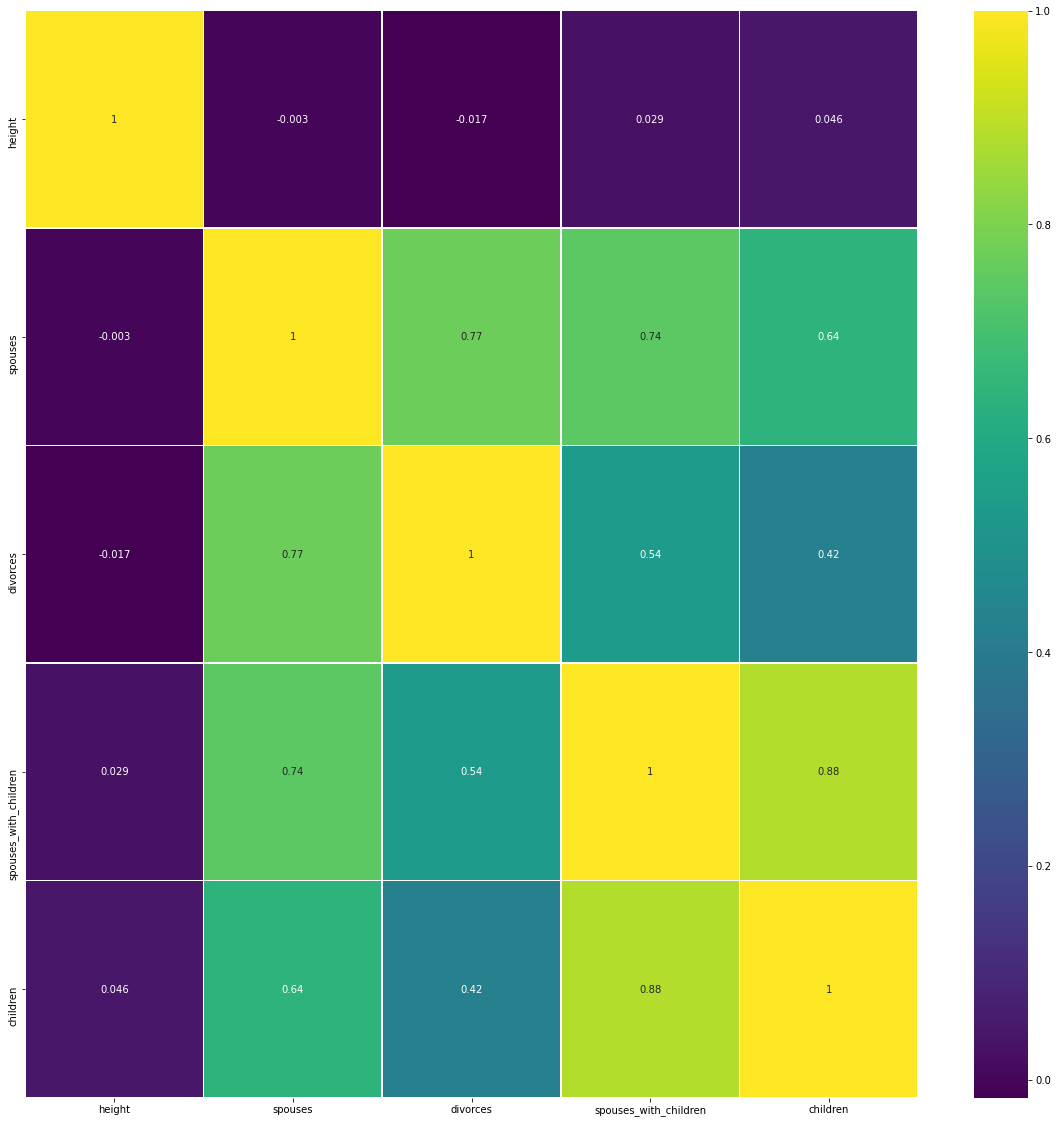

In [15]:
plt.figure(figsize=(20,20))
seaborn.heatmap(df_actors.corr(),annot=True,cmap='viridis',linewidth=0.5)

In [16]:
df_actors.isnull().mean()

name_id                  0.000000
name                     0.000000
birth_name               0.000000
height                   0.849915
bio                      0.312413
birth_details            0.628451
date_of_birth            0.628451
place_of_birth           0.650688
death_details            0.865864
date_of_death            0.865864
place_of_death           0.875588
reason_of_death          0.923770
spouses_string           0.847661
spouses                  0.000000
divorces                 0.000000
spouses_with_children    0.000000
children                 0.000000
dtype: float64

Также многие слобцы не содержат значений. С другой стороны, причина смерти актера обычно не влияет на просмотр фильма, так что это не должно являться проблемой.
Количество разводов ожидаемо перекликается с количеством супругов.

## Ratings
<a id='data_raitings'></a>

Наверное самая интересная таблица здесь, хотя некоторые столбцы явно линейно зависимы.
Оценим есть ли какая-то видимая диспропорция в данных, которая будет влиять на работу модели.

In [17]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85855 entries, tt0000009 to tt9914942
Data columns (total 49 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 85855 non-null  int64  
 1   weighted_average_vote      85855 non-null  float64
 2   total_votes                85855 non-null  int64  
 3   mean_vote                  85855 non-null  float64
 4   median_vote                85855 non-null  float64
 5   votes_10                   85855 non-null  int64  
 6   votes_9                    85855 non-null  int64  
 7   votes_8                    85855 non-null  int64  
 8   votes_7                    85855 non-null  int64  
 9   votes_6                    85855 non-null  int64  
 10  votes_5                    85855 non-null  int64  
 11  votes_4                    85855 non-null  int64  
 12  votes_3                    85855 non-null  int64  
 13  votes_2                    85855 non-nu

array([<AxesSubplot:ylabel='None'>], dtype=object)

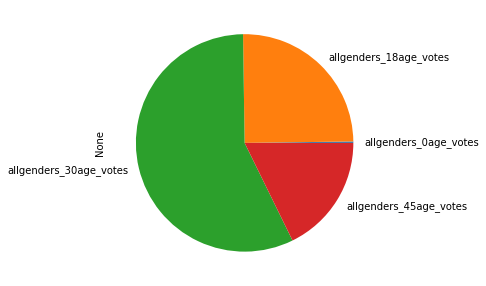

In [18]:
df_females_votes = pd.DataFrame(df_ratings,
                   columns=('allgenders_0age_votes','allgenders_18age_votes','allgenders_30age_votes','allgenders_45age_votes'))
(df_females_votes.mean(axis = 0)).plot.pie(subplots=True, figsize=(5, 5))

array([<AxesSubplot:ylabel='None'>], dtype=object)

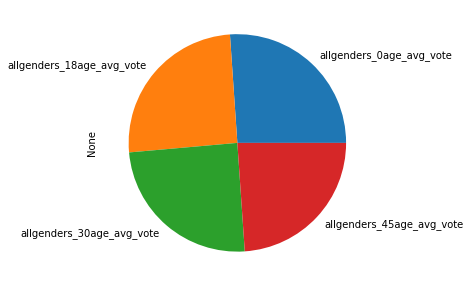

In [19]:
df_allgenders_votes = pd.DataFrame(df_ratings,
                   columns=('allgenders_0age_avg_vote','allgenders_18age_avg_vote','allgenders_30age_avg_vote','allgenders_45age_avg_vote'))
(df_allgenders_votes.mean(axis = 0)).plot.pie(subplots=True, figsize=(5, 5))

In [20]:
allgender_columns_names = ['allgenders_0age_avg_vote', 'allgenders_18age_avg_vote', 'allgenders_30age_avg_vote','allgenders_45age_avg_vote']
df_ratings[allgender_columns_names].isnull().mean()

allgenders_0age_avg_vote     0.611450
allgenders_18age_avg_vote    0.008223
allgenders_30age_avg_vote    0.000116
allgenders_45age_avg_vote    0.000932
dtype: float64

В данных есть явный возрастной перекос - пользователи до 18 лет не ставят оценки в 60% случаев, в то время как люди от 30 до 45 голосуют больше других. Столбец устредненных данных и убирает диспропорцию.  
Я также строила аналогичные графики для мужской и женской аудитории, там была такая же картина, так что решила ограничиться двумя круговыми диограммами.

<AxesSubplot:>

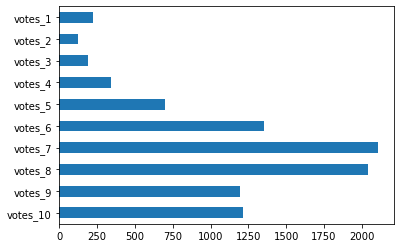

In [21]:
df_votes = pd.DataFrame(df_ratings,
                   columns=('votes_10','votes_9','votes_8','votes_7','votes_6','votes_5','votes_4','votes_3','votes_2','votes_1'))
(df_votes.mean(axis = 0)).plot.barh(stacked=True)

In [22]:
important_rating_columns = ['weighted_average_vote','total_votes','mean_vote','median_vote', 'us_voters_rating', 'non_us_voters_rating']

<AxesSubplot:>

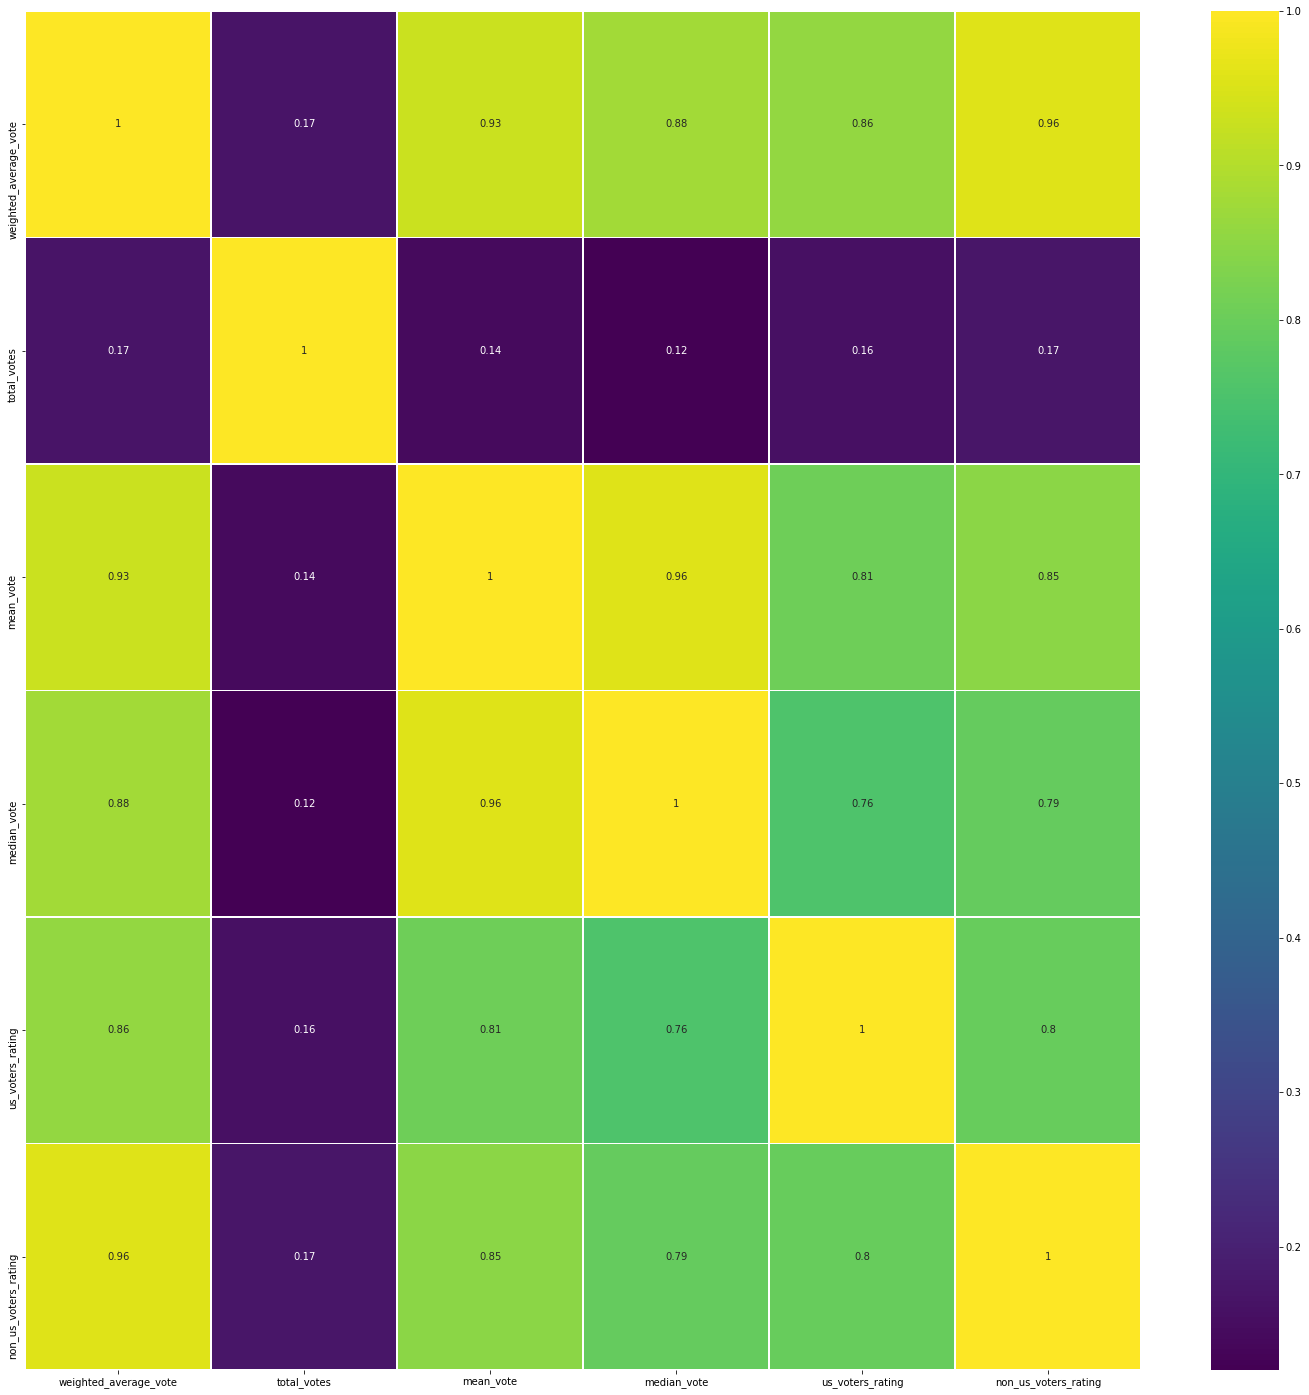

In [23]:
plt.figure(figsize=(25,25))
seaborn.heatmap(df_ratings[important_rating_columns].corr(),annot=True,cmap='viridis',linewidth=0.5)

In [24]:
df_new_ratings = df_ratings[important_rating_columns].fillna(value=0)

In [25]:
df_new_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85855 entries, tt0000009 to tt9914942
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   weighted_average_vote  85855 non-null  float64
 1   total_votes            85855 non-null  int64  
 2   mean_vote              85855 non-null  float64
 3   median_vote            85855 non-null  float64
 4   us_voters_rating       85855 non-null  float64
 5   non_us_voters_rating   85855 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 4.6+ MB


Данные выглядят сбалансированно в плане отметок - нет перекоса на 10 или 1.  
Из-за высокой коррелированности данных я не стала включать многие колонны из этого куска датасета в финальную версию для обучения.  
Коррелированность связана с тем, что некоторые признаки букально считались как линейная комбинация из других - например усредненные по полу отметки и число голосующих из (вне) штатов к числу всех голосовавших.

---
## Выбор алгоритма и Очистка данных
<a id='cleaning'></a>

На данном этапе становится понятно, что применить коллабаративный подход не получится, потому что отсутствуют данные о пользователях, кроме как оценки в засисимости от гендера и географии (штаты/не штаты), но и они усредненные.
Будем работать с данными которые репрезентуют фильмы - самое важное это каст включая сценаристов и режиссеров, год произодства и оценки. 
Хорошая новость в том, что **content-base** подход 
* не сторадает от недостатка информации о пользователе на старте, так как не таргетит его исключительно 
* даже любители жанрового кино будут получать рекомендации 
* сликшом популярные вещи могут не всплывать слишком часто (то, что нравится всем)

Однако пользователи не будут видеть рекомендации все того кластера контента, который они смотрят обычно.

Как основной алгоритм я буду использовать **линейное ядро** - скалярное произведение с переносом в другое пространство, где кластеры объектов могут быть линейно разделимы.  
Такой алгоритм должен хорошо сработать так как имеется множество строковых признаков, описывающих фильмы, для которых определено скалярное произведение - число совместно встречающихся подстрок.  
Как мера близости разных объектов будет использовано **косинусное расстрояние** - мера сходства между двумя векторами.  

Таким образом, **для решения данной задачи нужно выделить строковые признаки которые характеризуют кластеры лучшим образом, определить их комбинацию и выполнить линейное преобразование. Далее найти ближайшие объекты в новом пространстве - это и будут наиболее подходящие (похожие) фильмы, так как они лежат в одном кластере (рядом).**

Удалим столбцы со сликшом большим количеством пропусков, а также заполним пустые ячейки нулями или '.' в зависимости от данных типа данных в столбце.

In [26]:
df_films.isnull().sum(axis = 0)/len(df_films)

Unnamed: 0               0.000000
title                    0.000000
original_title           0.000000
year                     0.000000
date_published           0.000000
genre                    0.000000
duration                 0.000000
country                  0.000745
language                 0.009702
director                 0.001013
writer                   0.018310
production_company       0.051890
actors                   0.000804
description              0.024635
avg_vote                 0.000000
votes                    0.000000
budget                   0.723837
usa_gross_income         0.821490
worlwide_gross_income    0.638740
metascore                0.845029
reviews_from_users       0.088486
reviews_from_critics     0.137406
dtype: float64

In [27]:
print(f'columns before clean up {df_films.shape[1]}')
df_films = df_films.loc[:, df_films.isnull().mean() < .15]
print(f'columns after clean up {df_films.shape[1]}')

columns before clean up 22
columns after clean up 18


In [28]:
df_films = df_films.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' else x.fillna('.'))

In [29]:
df_films.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85855 entries, tt0000009 to tt9914942
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Unnamed: 0            85855 non-null  int64         
 1   title                 85855 non-null  object        
 2   original_title        85855 non-null  object        
 3   year                  85855 non-null  object        
 4   date_published        85855 non-null  datetime64[ns]
 5   genre                 85855 non-null  object        
 6   duration              85855 non-null  int64         
 7   country               85855 non-null  object        
 8   language              85855 non-null  object        
 9   director              85855 non-null  object        
 10  writer                85855 non-null  object        
 11  production_company    85855 non-null  object        
 12  actors                85855 non-null  object        
 13  descripti

Я не вижу смысла сливать все таблицы в одну из-за большого количества пропусков и линейной зависимости в данных, однако добавлю один столбец, который неплохо (судя по коэф. корреляции) репрезентует ratings таблицу.

In [30]:
assert len(df_films) == len(df_new_ratings['weighted_average_vote'])

In [31]:
df = df_films.copy(deep=True) #pd.concat([df_films, df_new_ratings], axis=1)
df['weighted_average_vote'] = df_ratings['weighted_average_vote']
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('original_title', axis=1,inplace=True)
df = df[30000:]  # мое железо не вывозит весь датасет так как не хватает памяти под работу с матрицами такого размера

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55855 entries, tt0117145 to tt9914942
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  55855 non-null  object        
 1   year                   55855 non-null  object        
 2   date_published         55855 non-null  datetime64[ns]
 3   genre                  55855 non-null  object        
 4   duration               55855 non-null  int64         
 5   country                55855 non-null  object        
 6   language               55855 non-null  object        
 7   director               55855 non-null  object        
 8   writer                 55855 non-null  object        
 9   production_company     55855 non-null  object        
 10  actors                 55855 non-null  object        
 11  description            55855 non-null  object        
 12  avg_vote               55855 non-null  float64       

In [33]:
df.head()

,title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,reviews_from_users,reviews_from_critics,weighted_average_vote
title_id,,,,,,,,,,,,,,,,,
tt0117145,Nacht der Gaukler,1996,1996-11-01,Drama,90,Switzerland,German,"Michael Steiner, Pascal Walder",Jürg Brändli,Kontraproduktion AG,"Pascal Ulli, Ingrid Sattes, Hans-Peter Ulli, T...",The defense minister of an unnamed European co...,6.8,101,0.0,3.0,6.8
tt0117148,Naisen logiikka,1999,1999-05-21,Comedy,70,Finland,Finnish,Spede Pasanen,Spede Pasanen,Spede-Tuotanto Oy,"Spede Pasanen, Simo Salminen, Hannele Lauri, R...",A sketch comedy loosely tied together by the i...,3.4,185,1.0,0.0,3.4
tt0117149,The Naked Detective,1996,1996-01-01,Comedy,84,USA,English,Ernest G. Sauer,"Ken Dashow, Ken Dashow",.,"J.B. Gardiner, Julia Parton, Gregory Tracy, Ta...",Low-rent private dick Sam Drake is called on t...,4.9,159,7.0,2.0,4.9
tt0117151,"Nan guo zai jian, nan guo",1996,1997-04-12,"Crime, Drama",124,"Taiwan, Japan","Mandarin, Hokkien",Hsiao-Hsien Hou,"T'ien-wen Chu, Jack Kao",3H Films,"Jieh-Wen King, Kuei-Ying Hsu, Annie Shizuka In...",A glimpse at the lives of two petty criminals ...,7.3,1473,8.0,21.0,7.3
tt0117155,Sekten,1997,1997-09-12,Thriller,87,Denmark,"Norwegian, Swedish, Danish",Susanne Bier,"Jakob Grønlykke, Peter Asmussen",Zentropa Entertainments,"Sofie Gråbøl, Ellen Hillingsø, Sverre Anker Ou...","Mona is a young woman, engaged to a man who ne...",4.6,422,3.0,2.0,4.6


In [34]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
duration,55855.0,102.229254,22.276153,41.0,89.0,97.0,110.0,808.0
avg_vote,55855.0,5.753800,1.302720,1.0,5.0,6.0,6.7,9.9
votes,55855.0,11025.492078,57660.946435,99.0,204.0,483.0,1805.5,2241615.0
reviews_from_users,55855.0,47.239441,199.492325,0.0,2.0,6.0,20.0,10472.0
reviews_from_critics,55855.0,27.418978,64.603595,0.0,1.0,6.0,20.0,999.0
weighted_average_vote,55855.0,5.753800,1.302720,1.0,5.0,6.0,6.7,9.9


Итак, оптимальный датасет состоит из  55855 строк и 17 столбцов, не содержит пропусков.

## Подготовка данных
<a id='data_preparation'></a>

Выберем признаки которые обеспечат наилучшую линейную разделимость пространства - они не должны быть линейно зависимы.  
Я буду использовать данные о стране, жанре и режиссере фильма. Сюда могли бы войти еще и актеры, но их в фильме может быть несколько и не факт что они будут стоять в порядке важности в сюжете.

Приведем все ячейки в упомянутых столбцах к общему виду - нижний регистр, без пробелов и знаков препинания.

In [35]:
df['country'] = df['country'].apply(lambda x: str(x.split(',')[0]) if len(x.split(',')) >=2 else x) # из всех стран выбираем первую

In [36]:
df['genre'] = df['genre'].str.lower().str.replace(",", "").str.replace(" ", "")
df['director'] = df['director'].str.lower().str.replace(",", "").str.replace(" ", "")
df['country'] = df['country'].str.lower().replace(",", "").str.replace(" ", "")

In [37]:
df['tags']= df['genre']+df['director'] + df['country']# новый столбец признаков, где они все были слиты в одну строку

---
## Модель
<a id='model'></a>

Токенизируем получившиеся строки - нормализуем их, уберем служебные части речи английского языка, а после преобразуем в численное представление, для дальнейшего извлечения признаков.

In [38]:
tf = TfidfVectorizer(min_df=1,norm=u'l2',analyzer='word' , lowercase=True,
                     ngram_range=(1, 2), stop_words='english')
tfidf_matrix = tf.fit_transform(df['tags'])
tfidf_matrix.shape

(55855, 58698)

In [39]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)  # создаем модель

In [40]:
df = df.reset_index()
titles = df['title']
indices = pd.Series(df.index, index=df['title'])

## Метрики

<a id='metrics'></a>

Получаем ближайшие по описанию (режиссер+страна+жанр) фильмы и отбираем из них топ20

In [41]:
def get_recommendations(title, indices):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1].any(), reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]  
    return titles.iloc[movie_indices]

In [42]:
test_samples = df.sample(int(len(df)*0.1)).index.values.tolist()  # берем кусок датасета для тестирования модели (10% потому что тут n^2 сложность, проблемы с железом)

# очевидно, мы не будеи брать новые значения потому что для них нужно будет считать все заново

Тут началось изобретение велосипеда.
Вопрос в том, что считать удачным или неудачным предсказанием и с какой вероятностью.
Можно было расставлять вероятности в зависимости от удаленности верхушки в топе.

Я решила сделать проще - смотрим на то, какая взвешенная средняя оценка у фильма и насколько рекомендуемые фильмы отклоняются от нее по той же взвешенной средней оценке. Если больше чем на единицу по модулю - то это фейл.
Если меньше, то вероятность строим в зависимости от абсолютного значения.

HBO MAX вдохновил меня на идею бизнес метрики - просмотр недавно вышедших фильмов, в случае их эксклюзивности для платформы, залог того, что пользователи будут оплачивать подписку ради доступа к новому контенту. Поэтому за рекомендацию фильма который вышел в течении полугода или месяца назад будет тикать отдельный счетчик, которым можно оценивать насколько хорошо рекомендуется новый контент.

Я взяла дату выхода последнего фильма и считала количество дней в рекомендуемых фильмах от нее. 

In [43]:
pred_limit = 5   #рекомендуем только 5 фильмов
y_true_array = np.zeros((len(test_samples),pred_limit))   # матрицы для метрик
y_scores_array = np.zeros((len(test_samples),pred_limit))
today = df['date_published'].max(axis=0)
last_mounth_films = 0        # счетчики рекомендаций нового контента
last_year_films = 0
for i in range(len(test_samples)):   
    sample = test_samples[i]
    sample_rate = df.loc[sample, 'weighted_average_vote']   
    sample_title = df.loc[sample, 'title']
    
    rec_indexes = get_recommendations(sample_title, indices).head(pred_limit).index[:pred_limit]
    for j in range(len(rec_indexes)):
        if np.absolute(sample_rate - df.loc[rec_indexes[j], 'weighted_average_vote']) < 1:
            y_true_array[i][j] = 1
            y_scores_array[i][j] = (1-np.absolute(sample_rate - df.loc[rec_indexes[j], 'weighted_average_vote'])*0.8)
        else:
            y_true_array[i][j] = 0
            y_scores_array[i][j] = 0.99
            
        enddt = pd.to_datetime(df.loc[rec_indexes[j], 'date_published'])
        gap = len(pd.date_range(start=enddt,end=pd.to_datetime(today),freq='M'))
        
        if gap <= 30:   
            last_mounth_films += 1
        elif gap <= 365:
            last_mounth_films += 1
            last_year_films += 1


In [44]:
#y_true_array = np.asmatrix(y_true_array)
#y_scores_array = np.asmatrix(y_scores_array)

In [45]:
print(f"average precision score: {round(average_precision_score(y_true=y_true_array, y_score=y_scores_array),4)}")
print(f"label ranking average precision score : {round(label_ranking_average_precision_score(y_true=y_true_array, y_score=y_scores_array),4)}")
print(f"dcg score : {round(dcg_score(y_true=y_true_array, y_score=y_scores_array),4)}")
print(f"ndcg score : {round(ndcg_score(y_true=y_true_array, y_score=y_scores_array),4)}")

average precision score: 0.3454
label ranking average precision score : 0.4544
dcg score : 0.8836
ndcg score : 0.5342


* **average precision score** - Средняя точность **34%** - без учета позиции. Ложных срабатываний больше чем верно предсказанных ответов
* **label ranking average precision score 45%** - выше средней точности, значит впереди идут все же более релевантные рекомендации. Но я предположу что оценка выше потому что меньший вес идет на плохие предсказания
* **dcg score 88%** - релевантные реакомендации дейтствительно стоят выше, значит первые рекомендуемые фильмы рекомендованы правильно согласно способу построения метрик
* **ndcg score 53%** - разница с не нормализованной метрикой огромна. Это явно показывает что такие результаты получены из-за способа подсчета y_true_array и y_scores_array

In [46]:
overall_films = len(test_samples)*5

In [47]:
print(f'{round(last_mounth_films/overall_films,4)}% film reliased less than month ago recommended')
print(f'{round(last_year_films/overall_films,4)}% film reliased less than years ago in recommendations')

0.9349% film reliased less than month ago recommended
0.9267% film reliased less than years ago in recommendations


**Бизнес метрика?** - рекомендации нового контента - за него больше платят.
Здесь что-то пошло не так с преобразованием datetime в пандасе, документация так и не поведала мне что именно
Значения точно не должны быть такими высокими - даты при построеннии модели вообще не учитывались, алгоритм не будет рекомендовать 90+ новых фильмов

In [52]:
last_mounth_films

26107

---
## Результаты и немного примеров
<a id='result'></a>

На примерах фильмов из поп-культуры субъективно вижу, что можель работает хорошо для своей сложности. С другой стороны, по метрика понятно, что выводов делать нельзя потому что они построены не правильно. 

Ниже обоснование того, почему я считаю свою модель как минимум удобоваримой.
Все названия фильмов были взяты из таблицы в самом низу ноутбука.

*Спасибо за потраченное время*

In [49]:
best_films = ['Toy Story 3 - La grande fuga',
'Avengers: Infinity War',
'Django Unchained',
'Titanic Review',
'Kill Bill: The Whole Bloody Affair',
'Iron Man',
'Matrix']

In [50]:
for film in best_films:
    print(f"Recommendations for {film.upper()}:")
    [print(recommendation) for recommendation in get_recommendations(film, indices).head(10).values ]
    print()

Recommendations for TOY STORY 3 - LA GRANDE FUGA:
Nacht der Gaukler
Naisen logiikka
The Naked Detective
Nan guo zai jian, nan guo
Sekten
Navajo Blues
Nemuru otoko
Never Ever
Never Met Picasso
New York Undercover Cop

Recommendations for AVENGERS: INFINITY WAR:
The Avengers - Agenti speciali
Il quinto elemento
Il mondo perduto - Jurassic Park
Starship Troopers - Fanteria dello spazio
Armageddon - Giudizio finale
Star Trek - L'insurrezione
X-Men
Laserhawk
Wing Commander - Attacco alla Terra
Planet of the Apes - Il pianeta delle scimmie

Recommendations for DJANGO UNCHAINED:
Nacht der Gaukler
Naisen logiikka
The Naked Detective
Nan guo zai jian, nan guo
Sekten
Navajo Blues
Nemuru otoko
Never Ever
Never Met Picasso
New York Undercover Cop

Recommendations for TITANIC REVIEW:
Titanic Review
Mr. Plinkett's Indiana Jones and the Kingdom of the Crystal Skull Review
Mr. Plinkett's Star Trek 2009 Review
Nacht der Gaukler
Naisen logiikka
The Naked Detective
Nan guo zai jian, nan guo
Sekten
Navajo

## Наверх
1. [Постановка задачи](#you_are_here)
1. [Анализ датасетов: films, titles, actors](#data_films)
2. [Анализ ratings](#data_raitins)
3. [Очистка данных](#cleaning)
4. [Подготовка данных](#data_preparation)
5. [Модель](#model)
6. [Анализ метрик](#metrics)
6. [Итоги](#conclusion)

In [51]:
df.loc[df['country'] == 'usa'].nlargest(50, 'weighted_average_vote')#'us_voters_rating')#'mean_vote')

,title_id,title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,reviews_from_users,reviews_from_critics,weighted_average_vote,tags
28809,tt1508669,Hopeful Notes,2010,2010-12-15,drama,94,usa,English,valeriozanoli,Valerio Zanoli,High Concept,"Walter Nudo, Colin Ross, Ian Poland, Laural Me...",A young violinist with leukemia brings hope an...,9.7,669,2.0,2.0,9.7,dramavaleriozanoliusa
24166,tt11164090,The Moving on Phase,2020,2020-05-11,comedy,85,usa,English,dontjernagel,Don Tjernagel,.,"Matt Anderson, Clint Boevers, Jillian Brown, C...",Piper is a young adult female that is forced i...,9.5,172,0.0,0.0,9.5,comedydontjernagelusa
22570,tt10218912,As I Am,2019,2019-12-06,dramafantasyromance,62,usa,English,anthonybawn,Anthony Bawn,APB Production,"Andre Myers, Jerimiyah Dunbar, Rodney Chester,...",A story of a young man running from the truth ...,9.3,1173,5.0,0.0,9.3,dramafantasyromanceanthonybawnusa
51109,tt6735740,Love in Kilnerry,2019,2019-06-23,comedy,100,usa,English,danielkeithsnorristurluson,Daniel Keith,Archway Pictures,"Daniel Keith, Kathy Searle, Tony Triano, James...",The elderly resident of a small remote town pa...,9.3,1239,17.0,11.0,9.3,comedydanielkeithsnorristurlusonusa
49258,tt5980638,The Transcendents,2018,2020-06-19,musicmysterythriller,96,usa,English,derekahonen,Derek Ahonen,.,"Rob Franco, Savannah Welch, Kathy Valentine, W...","Roger, a Rasputin-like drifter, is in search o...",9.2,1450,3.0,4.0,9.2,musicmysterythrillerderekahonenusa
49532,tt6074834,Delaware Shore,2018,2018-12-21,drama,98,usa,English,raghavperi,"Raghav Peri, Michaelangelo Rodriguez",Avocado Media,"James Robinson Jr., Kevin D. Benton, Bella Don...",A Holocaust survivor who escapes the concentra...,9.1,507,12.0,4.0,9.1,dramaraghavperiusa
18078,tt0468569,Il cavaliere oscuro,2008,2008-07-23,actioncrimedrama,152,usa,"English, Mandarin",christophernolan,"Jonathan Nolan, Christopher Nolan",Warner Bros.,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",When the menace known as the Joker wreaks havo...,9.0,2241615,6938.0,423.0,9.0,actioncrimedramachristophernolanusa
2487,tt0137523,Fight Club,1999,1999-10-29,drama,139,usa,English,davidfincher,"Chuck Palahniuk, Jim Uhls",Fox 2000 Pictures,"Edward Norton, Brad Pitt, Meat Loaf, Zach Gren...",An insomniac office worker and a devil-may-car...,8.8,1807440,3758.0,370.0,8.8,dramadavidfincherusa
15959,tt0419781,Graves End,2005,2005-04-22,thrillermystery,90,usa,English,jamesmarlowe,"Rick Askew, James Marlowe",Marlowe/Pugnetti Company,"Eric Roberts, Steven Williams, Daniel Roebuck,...",When society turns their back on reformed felo...,8.8,6494,25.0,1.0,8.8,thrillermysteryjamesmarloweusa
23529,tt10765852,Metallica and San Francisco Symphony S&M2,2019,2019-10-18,music,150,usa,English,wayneisham,.,Prime Zero Productions,"Edgar Barradas, Kirk Hammett, James Hetfield, ...",Metallica and the San Francisco Symphony perfo...,8.8,1046,25.0,2.0,8.8,musicwayneishamusa


<a id='metrics'></a>

<a id='conclusion'></a>